In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import regularizers


In [2]:
# Define network and training parameters
EPOCHS = 50
IMAGE_SIZE = (128, 128)
INPUT_SHAPE = (128, 128, 3)
SEED = 123
BATCH_SIZE = 32
BUFFER_SIZE = 1000  # Increased buffer size for better shuffling
LEARNING_RATE = 0.0001  # Reduced learning rate

images_dir = 'arcgis-survey-images'

In [3]:
# Get class names (subdirectories) and assign numeric labels
class_names = sorted([d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))])
class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}

print(f"Classes found: {class_names}")


Classes found: ['Chinche salivosa', 'Clororis', 'Hoja sana', 'Roya naranja', 'Roya purpura']


In [4]:
# Create lists to store file paths and labels
image_paths = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(images_dir, class_name)
    for fname in os.listdir(class_dir):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_paths.append(os.path.join(class_dir, fname))
            labels.append(class_to_label[class_name])

In [5]:
# Create the DataFrame
data_df = pd.DataFrame({
    'filepath': image_paths,
    'label': labels
})

print(f"Original class distribution:\n{data_df['label'].value_counts()}")

Original class distribution:
label
3    1001
2     837
0     825
1     404
4     222
Name: count, dtype: int64


In [6]:
# Split into training and validation sets
train_df, val_df = train_test_split(
    data_df,
    test_size=0.2,
    stratify=data_df['label'],
    random_state=SEED
)

In [7]:
print(f"Class distribution in training before balancing:\n{train_df['label'].value_counts()}")
print(f"Class distribution in validation:\n{val_df['label'].value_counts()}")

# Step 1: Examine the Class Distribution in Training Set
print("Class distribution in the training set:")
print(train_df['label'].value_counts())

Class distribution in training before balancing:
label
3    801
2    669
0    660
1    323
4    178
Name: count, dtype: int64
Class distribution in validation:
label
3    200
2    168
0    165
1     81
4     44
Name: count, dtype: int64
Class distribution in the training set:
label
3    801
2    669
0    660
1    323
4    178
Name: count, dtype: int64


In [8]:
# Step 2: Upsample Minority Classes
# Separate classes
df_list = [train_df[train_df['label'] == i] for i in train_df['label'].unique()]

# Find the maximum class count
max_count = train_df['label'].value_counts().max()

# Upsample minority classes
df_upsampled = [df if len(df) == max_count else resample(df, replace=True, n_samples=max_count, random_state=SEED) for df in df_list]

# Combine back to a single DataFrame
train_df_balanced = pd.concat(df_upsampled)

# Shuffle the DataFrame
train_df_balanced = train_df_balanced.sample(frac=1, random_state=SEED).reset_index(drop=True)

print("Class distribution after upsampling:")
print(train_df_balanced['label'].value_counts())

Class distribution after upsampling:
label
4    801
1    801
3    801
0    801
2    801
Name: count, dtype: int64


In [9]:
# Step 3: Update the Data Pipeline
# Function to extract paths and labels from DataFrame
def path_to_image_label(df):
    return df['filepath'].values, df['label'].values


In [10]:
# Extract paths and labels from the balanced DataFrame
train_paths_balanced, train_labels_balanced = path_to_image_label(train_df_balanced)
val_paths, val_labels = path_to_image_label(val_df)

# Create TensorFlow Datasets
train_ds_balanced = tf.data.Dataset.from_tensor_slices((train_paths_balanced, train_labels_balanced))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

# Step 5: Verify Image Preprocessing and Enhance Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

In [11]:
def load_and_preprocess_image_flexible(path, label):
    try:
        image = tf.io.read_file(path)
        # Detect file type and decode accordingly
        file_extension = tf.strings.lower(tf.strings.split(path, '.')[-1])
        image = tf.case([
            (tf.equal(file_extension, 'jpg'), lambda: tf.image.decode_jpeg(image, channels=3)),
            (tf.equal(file_extension, 'jpeg'), lambda: tf.image.decode_jpeg(image, channels=3)),
            (tf.equal(file_extension, 'png'), lambda: tf.image.decode_png(image, channels=3)),
        ], default=lambda: tf.image.decode_jpeg(image, channels=3), exclusive=True)
        image = tf.image.resize(image, IMAGE_SIZE)
        image = data_augmentation(image)
        image = image / 255.0  # Normalize to [0,1]
        return image, label
    except tf.errors.InvalidArgumentError:
        tf.print(f"Error processing image: {path}")
        return tf.zeros(INPUT_SHAPE), -1

In [12]:
def filter_invalid_images(image, label):
    # Filter out invalid labels (e.g., -1)
    return tf.not_equal(label, -1)

In [13]:
# Apply preprocessing and filter invalid images
train_ds_balanced = train_ds_balanced.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
train_ds_balanced = train_ds_balanced.filter(filter_invalid_images)
train_ds_balanced = train_ds_balanced.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = val_ds.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.filter(filter_invalid_images)
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Step 6: Adjust Model Hyperparameters
# Reduced learning rate has been set above

# Step 7: Unfreeze More Layers in the Base Model
# Load the base model (MobileNetV2)
base_model = MobileNetV2(input_shape=INPUT_SHAPE,
                         include_top=False,
                         weights='imagenet')

# Unfreeze more layers for fine-tuning
for layer in base_model.layers[:75]:
    layer.trainable = False
for layer in base_model.layers[75:]:
    layer.trainable = True

base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,067,712 (7.89 MB)

 Non-trainable params: 190,272 (743.25 KB)

In [15]:
# Define the full model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,067,712 (7.89 MB)

 Non-trainable params: 190,272 (743.25 KB)

In [16]:
# Compile the model with a reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True)

checkpoint_path = 'best_model.keras'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              min_lr=1e-6,
                              verbose=1)

tensorboard_log_dir = "logs/fit/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

In [17]:
# Step 9: Monitor Training Closely
# Train the model
history = model.fit(
    train_ds_balanced,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard_callback]
)

Epoch 1/50
    126/Unknown 53s 275ms/step - accuracy: 0.3820 - loss: 3.8468

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 4.24641, saving model to best_model.keras
126/126 ━━━━━━━━━━━━━━━━━━━━ 61s 340ms/step - accuracy: 0.3830 - loss: 3.8442 - val_accuracy: 0.4164 - val_loss: 4.2464 - learning_rate: 1.0000e-04
Epoch 2/50
 45/126 ━━━━━━━━━━━━━━━━━━━━ 22s 279ms/step - accuracy: 0.7289 - loss: 2.9091

In [ ]:
# Step 10: Visualize Training Performance
# Plot loss and accuracy
metrics = history.history
plt.figure(figsize=(16, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], label='Training')
plt.plot(history.epoch, metrics['val_loss'], label='Validation')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], label='Training')
plt.plot(history.epoch, metrics['val_accuracy'], label='Validation')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Step 11: Evaluate the Improved Model
# Create a test dataset from the validation set
test_ds = val_ds.shard(num_shards=2, index=1)

# Evaluate the model on the test set
test_results = model.evaluate(test_ds, return_dict=True)
print("Test set evaluation:")
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

# Obtain predictions
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate confusion matrix
conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes).numpy()

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Updated classification report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [ ]:
# Step 12: Visualize Some Predictions
import random

# Get a batch from the test dataset
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = labels.numpy()
    break

# Randomly select images to display
indices = random.sample(range(images.shape[0]), min(9, images.shape[0]))

plt.figure(figsize=(15, 15))
for i, idx in enumerate(indices):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].numpy())
    true_label = class_names[true_classes[idx]]
    pred_label = class_names[pred_classes[idx]]
    plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.axis("off")
plt.show()

In [88]:
# # Función para extraer rutas y etiquetas del DataFrame
# def path_to_image_label(df):
#     return df['filepath'].values, df['label'].values

# # Extraer rutas y etiquetas
# train_paths, train_labels = path_to_image_label(train_df)
# val_paths, val_labels = path_to_image_label(val_df)

# # Crear TensorFlow Datasets
# train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
# val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

# # Aplicar la función de preprocesamiento y filtrar imágenes inválidas
# train_ds = train_ds.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.filter(filter_invalid_images)
# train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# val_ds = val_ds.map(load_and_preprocess_image_flexible, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.filter(filter_invalid_images)
# val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


In [89]:
# # Verificar los datasets
# for images, labels in train_ds.take(1):
#     print(f"Batch de entrenamiento - imágenes: {images.shape}, etiquetas: {labels.shape}")

# for images, labels in val_ds.take(1):
#     print(f"Batch de validación - imágenes: {images.shape}, etiquetas: {labels.shape}")


Batch de entrenamiento - imágenes: (32, 128, 128, 3), etiquetas: (32,)
Batch de validación - imágenes: (32, 128, 128, 3), etiquetas: (32,)


In [90]:
# # Cargar el modelo base (MobileNetV2)
# base_model = MobileNetV2(input_shape=INPUT_SHAPE,
#                          include_top=False,
#                          weights='imagenet')

# # Congelar las primeras 100 capas del modelo base
# for layer in base_model.layers[:100]:
#     layer.trainable = False

# base_model.summary()


Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [91]:
# # Definir el modelo completo
# model = tf.keras.models.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(len(class_names), activation='softmax')  # Usar 'softmax' y from_logits=False
# ])

# model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 1,861,440 (7.10 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [92]:
# # Compilar el modelo con una tasa de aprendizaje fija
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#               metrics=['accuracy'])


In [93]:
# early_stop = EarlyStopping(monitor='val_loss',
#                            patience=10,
#                            restore_best_weights=True)


In [94]:
# checkpoint_path = 'best_model.keras'
# model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
#                                    monitor='val_loss',
#                                    save_best_only=True,
#                                    verbose=1)


In [95]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss',
#                               factor=0.2,
#                               patience=5,
#                               min_lr=1e-6,
#                               verbose=1)


In [96]:
# tensorboard_log_dir = "logs/fit/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)


In [97]:
# # Entrenamiento del modelo
# history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=EPOCHS,
#     class_weight=class_weights_dict,  # Aplicar ponderaciones de clase
#     callbacks=[early_stop, model_checkpoint, reduce_lr, tensorboard_callback]
# )


Epoch 1/50


     83/Unknown 31s 232ms/step - accuracy: 0.5041 - loss: 2.5859

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 5.15500, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 38s 318ms/step - accuracy: 0.5049 - loss: 2.5827 - val_accuracy: 0.3389 - val_loss: 5.1550 - learning_rate: 0.0010
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6451 - loss: 1.7394
Epoch 2: val_loss improved from 5.15500 to 3.24945, saving model to best_model.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 289ms/step - accuracy: 0.6456 - loss: 1.7378 - val_accuracy: 0.3237 - val_loss: 3.2494 - learning_rate: 0.0010
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7503 - loss: 1.2782
Epoch 3: val_loss did not improve from 3.24945
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 284ms/step - accuracy: 0.7505 - loss: 1.2775 - val_accuracy: 0.4559 - val_loss: 10.9244 - learning_rate: 0.0010
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7677 - loss: 1.0166
Epoch 4: val_loss did not improve from 3.24945
83/83 ━━━━━━━━━━━━━━━━━━━━ 24s 286ms/step - accuracy: 

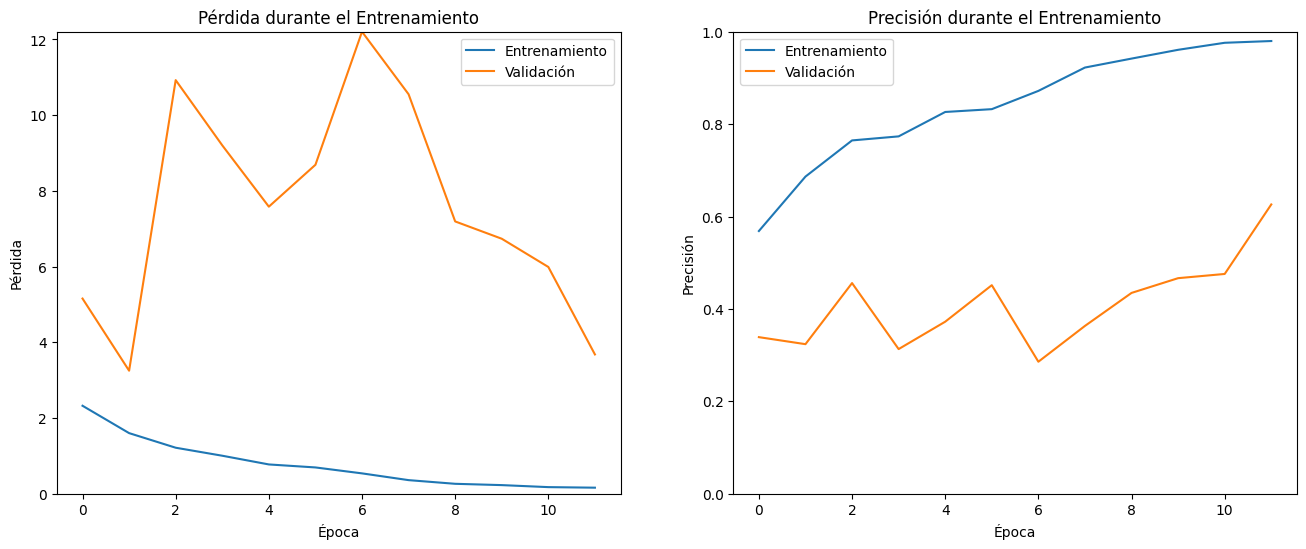

In [98]:
# # Gráfica de la pérdida y precisión
# metrics = history.history
# plt.figure(figsize=(16, 6))

# # Pérdida
# plt.subplot(1, 2, 1)
# plt.plot(history.epoch, metrics['loss'], label='Entrenamiento')
# plt.plot(history.epoch, metrics['val_loss'], label='Validación')
# plt.legend()
# plt.ylim([0, max(metrics['loss'] + metrics['val_loss'])])
# plt.ylabel('Pérdida')
# plt.xlabel('Época')
# plt.title('Pérdida durante el Entrenamiento')

# # Precisión
# plt.subplot(1, 2, 2)
# plt.plot(history.epoch, metrics['accuracy'], label='Entrenamiento')
# plt.plot(history.epoch, metrics['val_accuracy'], label='Validación')
# plt.legend()
# plt.ylim([0, 1])
# plt.ylabel('Precisión')
# plt.xlabel('Época')
# plt.title('Precisión durante el Entrenamiento')

# plt.show()


In [99]:
# # Crear un conjunto de test a partir del conjunto de validación
# test_ds = val_ds.shard(num_shards=2, index=1)

# # Evaluar el modelo en el conjunto de test
# test_results = model.evaluate(test_ds, return_dict=True)
# print("Resultados de evaluación en test set:")
# for metric, value in test_results.items():
#     print(f"{metric}: {value:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.2687 - loss: 3.4076
Resultados de evaluación en test set:
accuracy: 0.3156
loss: 3.3004


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step


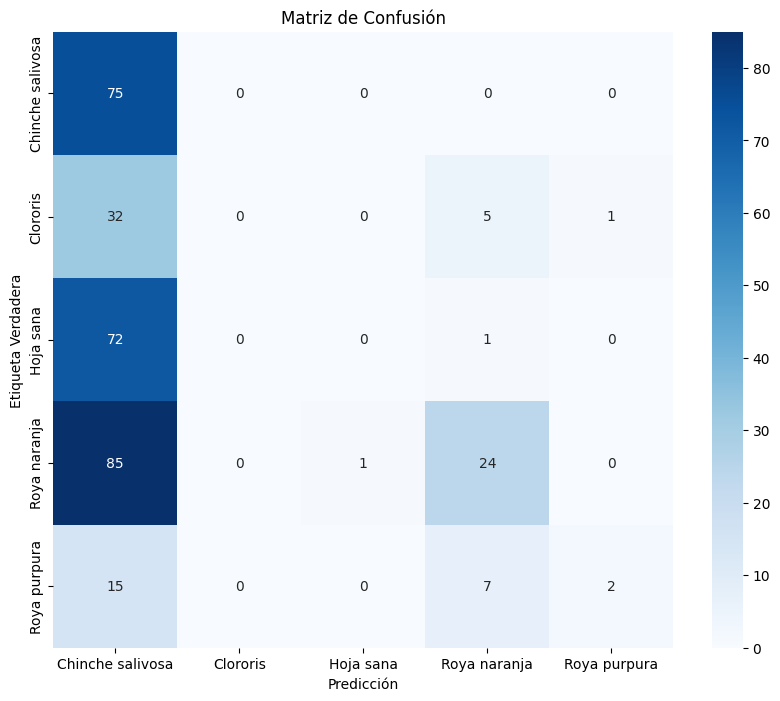

In [100]:
# # Obtener predicciones
# y_pred = model.predict(test_ds)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Obtener etiquetas verdaderas
# y_true = np.concatenate([y for x, y in test_ds], axis=0)

# # Calcular la matriz de confusión
# conf_matrix = tf.math.confusion_matrix(y_true, y_pred_classes).numpy()

# # Visualizar la matriz de confusión
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='g', cmap='Blues')
# plt.xlabel('Predicción')
# plt.ylabel('Etiqueta Verdadera')
# plt.title('Matriz de Confusión')
# plt.show()


In [101]:
# # Reporte de clasificación
# print("Reporte de clasificación:")
# print(classification_report(y_true, y_pred_classes, target_names=class_names))
 

Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.27      1.00      0.42        75
        Clororis       0.00      0.00      0.00        38
       Hoja sana       0.00      0.00      0.00        73
    Roya naranja       0.65      0.22      0.33       110
    Roya purpura       0.67      0.08      0.15        24

        accuracy                           0.32       320
       macro avg       0.32      0.26      0.18       320
    weighted avg       0.34      0.32      0.22       320



C:\Users\ealda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ealda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ealda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati